# PPO

The goal of this exercise is to use the `tianshou` library to apply PPO on the cartpole environment. `tianshou` is the latest and most up-to-date DRL library. It is based on pytorch for the deep networks and is the only library currently compatible with gymnasium, not gym.

Github: <https://github.com/thu-ml/tianshou> \
Documentation: <https://tianshou.readthedocs.io/en/latest>

Install it in your virtual environment simply with:

```bash
pip install -U tianshou
```

It will also install pytorch, which becomes double use with tensorflow, but well, storage is cheap...

Let's first import the usual stuff:

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium pygame moviepy
    !pip install -U tianshou

In [2]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from collections import deque

import gymnasium as gym
print("gym version:", gym.__version__)

import tianshou as ts

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

import pygame
from moviepy.editor import ImageSequenceClip, ipython_display


class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.
    
    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []

gym version: 0.28.1


/Users/vitay/.virtualenvs/tianshou/lib/python3.11/site-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


## tianshou

### Structure

``tianshou`` provides an implementation of most model-free algorithms seen in the course: DQN and its variants, A3C, DDPG, PPO and more. It also has several offline RL algorithms. You can see the list of algorithms here:

<https://tianshou.readthedocs.io/en/latest/index.html>

``tianshou`` relies on several concepts, which are explained here:

<https://tianshou.readthedocs.io/en/latest/01_tutorials/01_concepts.html#>

![](https://tianshou.readthedocs.io/en/latest/_images/concepts_arch2.png)

* The **policy** is actually the DRL algorithm (DQN, PPO), not the mapping from states into actions used in the course. It relies on one (or more) neural networks called the **model**.
* The interaction of the policy with the environment is done by the **collector**. By default, the collector used **distributed learning**, i.e. it uses parallel workers to interact with copies of the environment, thereby speeding up data collection. This is used even for algorithms which do not need distributed learning (DQN), as it is only beneficial. 
* The data collected by the collector is stored in a **buffer**, which can be an ERM for off-policy algorithms or a temporary buffer for on-policy ones.
* The (distributed) data is stored in **batches**. How data circulates between the collector, the policy and the buffer during training is controlled by the **trainer**.

Let's demonstrate this interaction with a dummy DQN network on Cartpole:

In [3]:
env = gym.make('CartPole-v0')

### Policy

The first step is to create the neural network for the DQN network. It must have `env.observation_space.shape=4` input neurons and `env.action_space.n=2` discrete output neurons. Let's put a single hidden layer with 32 neurons for now:

In [4]:
net = ts.utils.net.common.Net(
    env.observation_space.shape,
    env.action_space.n,
    hidden_sizes=[64, 64],
    device=device,
).to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)

`optim` is the Adam optimizer in pytorch, modifying all parameters (weights and biases) of the value network. Check the doc of `Net()` if you want a more specific architecture.

The output layer of the network is discrete, so that tianshou knows how to sample an action from the output (here the output neurons represent the Q-values, but it could be logits of a continuous policy). 

Now that we have the neural network, we can create the DQN policy object:

In [5]:
policy = ts.policy.DQNPolicy(
    model=net, # value network
    optim=optim, # optimizer
    discount_factor=0.95, # gamma
    target_update_freq=1000, # how often to update the target network
    action_space=env.action_space, # action space
)
policy.set_eps(0.1) # epsilon-greedy action selection

Check the doc of `DQNPolicy` for additional parameters (e.g. to implement a double duelling DQN).

We can now use the policy to interact with the environment as usual and visualize a trial with an untrained network:

Return: 10.0
MoviePy - Building file videos/cartpole-before.gif with imageio.



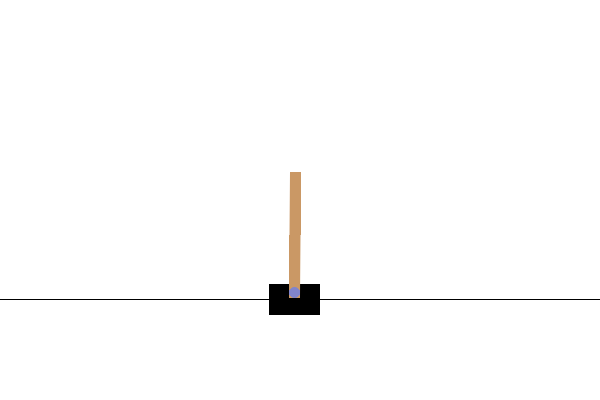

In [6]:
# Evaluation mode
policy.eval() 

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:

    # Select an action from the learned policy
    action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0]
    
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)

    # End of the episode
    done = terminal or truncated

    # Update undiscounted return
    return_episode += reward
    
    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-before.gif"
recorder.make_video(video)
ipython_display(video)

The action selection is done by calling `policy.forward()` on a batch of data containing only the current state:

```python
action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0]
```

### Collector

As we have seen in the DQN exercise, using a neural network with a batch size of 1 is extremely inefficient and slow. It is much better to use **distributed learning** and parallel workers to collect data. That way, we can form a minibatch of states that can be processed efficiently by the NN. 

In [7]:
collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=True
)

`policy` is the exploration policy. The `exploration_noise` flag allows to switch exploration on and off. For a discrete DQN policy, this impacts the $\epsilon$-greedy action selection scheme, but other algorithms might use another mechanism (softmax, Gaussian policies, Ornstein-Uhlenbeck, noisy parameters, etc).

`ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)])` means that we create 10 copies of the Cartpole environment which will be acted upon in parallel using the policy.

Let's collect some data with the collector. We can either collect a fixed number of steps (over the parallel workers) or episodes. Let's start with 10 steps:

In [8]:
collector.collect(n_step=10)

{'n/ep': 0,
 'n/st': 10,
 'rews': array([], dtype=float64),
 'lens': array([], dtype=int64),
 'idxs': array([], dtype=int64),
 'rew': 0,
 'len': 0,
 'rew_std': 0,
 'len_std': 0}

That's weird, we apparently did not receive any reward. Let's try to collect more steps.

In [9]:
collector.collect(n_step=1000)

{'n/ep': 98,
 'n/st': 1000,
 'rews': array([ 8.,  9.,  9., 10., 10., 10., 11., 12., 12., 13.,  8.,  9., 10.,
        10.,  9., 11., 10.,  9., 10., 17., 10., 10., 10., 11., 10., 10.,
        10., 10., 11.,  8., 10., 10., 10., 10.,  8., 11.,  9., 10., 14.,
         9., 10.,  9., 10., 10., 13.,  9., 11., 11., 10., 10.,  9.,  9.,
        13.,  9.,  9., 10.,  9., 10.,  8., 10., 10.,  8.,  9., 10., 10.,
        11.,  9., 12., 10., 10., 13., 11.,  9., 10., 11., 10., 12., 10.,
         8.,  9.,  9.,  9., 10., 11., 10.,  9., 10.,  9.,  9.,  9., 12.,
        10.,  9.,  9., 10., 10., 12.,  9.]),
 'lens': array([ 8,  9,  9, 10, 10, 10, 11, 12, 12, 13,  8,  9, 10, 10,  9, 11, 10,
         9, 10, 17, 10, 10, 10, 11, 10, 10, 10, 10, 11,  8, 10, 10, 10, 10,
         8, 11,  9, 10, 14,  9, 10,  9, 10, 10, 13,  9, 11, 11, 10, 10,  9,
         9, 13,  9,  9, 10,  9, 10,  8, 10, 10,  8,  9, 10, 10, 11,  9, 12,
        10, 10, 13, 11,  9, 10, 11, 10, 12, 10,  8,  9,  9,  9, 10, 11, 10,
         9, 10,  9, 

Alright, returns are only reported at the end of an episode. With 1000 steps (in parallel over 10 workers, i.e. each of them did 100 steps), we collected around 100 episodes of length 9 or 10, i.e. the cartpole falls right away, as expected with a random policy.

Can we collect complete episodes? Yes:

In [10]:
collector.collect(n_episode=10)

{'n/ep': 10,
 'n/st': 71,
 'rews': array([10.,  9., 11., 10.,  8.,  9., 10.,  9., 10., 10.]),
 'lens': array([10,  9, 11, 10,  8,  9, 10,  9, 10, 10]),
 'idxs': array([2, 5, 7, 3, 9, 0, 1, 4, 8, 6]),
 'rew': 9.6,
 'len': 9.6,
 'rew_std': 0.8,
 'len_std': 0.8}


But where is the data, i.e. the collected transitions? Nowhere, because we forgot to create a buffer to store them. Let's fix that mistake.

In [11]:
collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    buffer=ts.data.VectorReplayBuffer(1000, 10),
    exploration_noise=True
)

We preallocate an ERM of max 1000 transitions for each of the 10 workers. One could use a single replay buffer 10 times bigger, but tianshou requires it . Let's collect some episodes and look at the data stored in the first buffer:

In [12]:
collector.collect(n_episode=10)
collector.buffer.buffers[0]

ReplayBuffer(
    obs: array([[ 3.4645274e-02, -3.8563393e-02,  2.8588787e-02,  4.0672716e-02],
                [ 3.3874005e-02,  1.5613718e-01,  2.9402241e-02, -2.4285485e-01],
                [ 3.6996752e-02,  3.5082710e-01,  2.4545144e-02, -5.2612048e-01],
                [ 4.4013292e-02,  5.4559523e-01,  1.4022734e-02, -8.1096911e-01],
                [ 5.4925196e-02,  7.4052227e-01, -2.1966479e-03, -1.0992084e+00],
                [ 6.9735639e-02,  9.3567306e-01, -2.4180816e-02, -1.3925797e+00],
                [ 8.8449106e-02,  1.1310875e+00, -5.2032411e-02, -1.6927242e+00],
                [ 1.1107086e-01,  1.3267703e+00, -8.5886896e-02, -2.0011418e+00],
                [ 1.3760626e-01,  1.5226773e+00, -1.2590973e-01, -2.3191388e+00],
                [ 1.6805981e-01,  1.7187009e+00, -1.7229250e-01, -2.6477661e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
  

We see that each element of the transitions (s, a, r, s', done, terminated) is saved in a preallocated array of 1000 entries. The first replay buffer has only saved one short episode, so most of the data is zero.

Sampling a minibatch of transitions is easy:

In [13]:
collector.buffer.sample(10)

(Batch(
     obs: array([[ 0.06973564,  0.93567306, -0.02418082, -1.3925797 ],
                 [ 0.00501526,  0.438202  , -0.00610071, -0.5498225 ],
                 [ 0.00501526,  0.438202  , -0.00610071, -0.5498225 ],
                 [ 0.08791052,  1.4160656 , -0.12085497, -2.0735345 ],
                 [-0.00449122,  0.5818429 ,  0.01416115, -0.8354608 ],
                 [ 0.1239062 ,  1.754971  , -0.17513801, -2.6740465 ],
                 [-0.04072677,  0.42806664, -0.00650083, -0.5649815 ],
                 [-0.01800847,  0.19060245, -0.03275078, -0.3052972 ],
                 [ 0.04785302,  0.36885726, -0.01701378, -0.5969896 ],
                 [-0.01481533, -0.01626822, -0.01261962, -0.03139872]],
                dtype=float32),
     act: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
     rew: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
     terminated: array([False, False, False, False, False,  True, False, False, False,
                        False]),
     truncated: array

The transitions come randomly from the workers, so we do not need to worry about it.

We can reset the buffers with the following command:

In [14]:
collector.reset_buffer(keep_statistics=False)

If we print the buffer, data still seems to be there:

In [15]:
collector.buffer.buffers[0]

ReplayBuffer(
    obs: array([[ 3.4645274e-02, -3.8563393e-02,  2.8588787e-02,  4.0672716e-02],
                [ 3.3874005e-02,  1.5613718e-01,  2.9402241e-02, -2.4285485e-01],
                [ 3.6996752e-02,  3.5082710e-01,  2.4545144e-02, -5.2612048e-01],
                [ 4.4013292e-02,  5.4559523e-01,  1.4022734e-02, -8.1096911e-01],
                [ 5.4925196e-02,  7.4052227e-01, -2.1966479e-03, -1.0992084e+00],
                [ 6.9735639e-02,  9.3567306e-01, -2.4180816e-02, -1.3925797e+00],
                [ 8.8449106e-02,  1.1310875e+00, -5.2032411e-02, -1.6927242e+00],
                [ 1.1107086e-01,  1.3267703e+00, -8.5886896e-02, -2.0011418e+00],
                [ 1.3760626e-01,  1.5226773e+00, -1.2590973e-01, -2.3191388e+00],
                [ 1.6805981e-01,  1.7187009e+00, -1.7229250e-01, -2.6477661e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
                [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
  

But sampling returns an error:

In [16]:
collector.buffer.sample(10)

ValueError: probabilities contain NaN

### Interaction loop

We do not even need to actually sample the buffer, because `policy.update()` takes the buffer and a batch size as input. The following code implements DQN on Cartpole, with an okayish choice of hyperparameters. The main interaction loop consists of:

1. `collector.collect()`: Collect 100 samples using the 10 workers and store them in the ERM.
2. `policy.update()`: Sample `repeat=10` minitaches of 64 transitions from the buffer and learn from them.
3. `test_collector.collect()`: Test the performance by running 10 episodes without exploration.


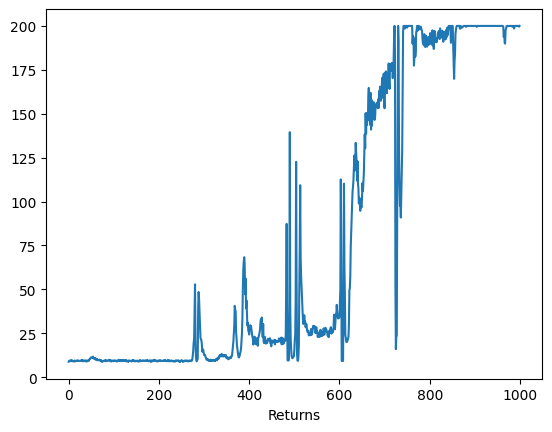

In [17]:
# Model
net = ts.utils.net.common.Net(
    env.observation_space.shape,
    env.action_space.n,
    hidden_sizes=[64, 64],
    device=device,
).to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)

# Policy
policy = ts.policy.DQNPolicy(
    model=net, # value network
    optim=optim, # optimizer
    discount_factor=0.99, # gamma
    estimation_step=1, # n-step returns
    is_double=False, # double Q-learning
    target_update_freq=120, # how often to update the target network
    action_space=env.action_space, # action space
)
policy.set_eps(0.1) # epsilon-greedy action selection

# Collector for training
collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    buffer=ts.data.VectorReplayBuffer(20000, 10),
    exploration_noise=True
)
# Collector for testing (without exploration). No need for a buffer
test_collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=False
)
# Pre-fill the training buffer with random transitions
collector.collect(n_step=1000, random=True)

# Interaction
returns = []
for iteration in range(1000):

    # Training mode
    policy.train()
    
    # Collect transitions
    result = collector.collect(n_step=100)

    # Train DQN network on minibatch
    policy.update(
        buffer=collector.buffer,
        sample_size=0, # use the whole buffer
        batch_size=64,
        repeat=10,
    )

    # Test 10 episodes
    policy.eval()
    result = test_collector.collect(n_episode=10)
    mean_reward = result['rew']
    #print(iteration, ":", mean_reward)
    returns.append(mean_reward)

plt.figure()
plt.plot(np.array(returns))
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.show()

Return: 200.0
MoviePy - Building file videos/cartpole-dqn.gif with imageio.



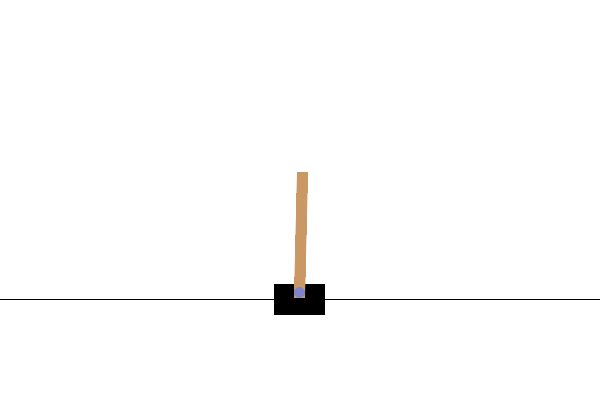

In [18]:
# Evaluation mode
policy.eval() 

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:
    # Select an action from the learned policy
    action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0]
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)
    # End of the episode
    done = terminal or truncated
    # Update undiscounted return
    return_episode += reward
    # Go in the next state
    state = next_state
print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-dqn.gif"
recorder.make_video(video)
ipython_display(video)

**Q:** Understand and run the code. Experiment with the hyperparameters and compare them to the previous exercise. In particular, what is `estimation_step=3` in the constructor of PPO? What is its influence?

**Q:** Implement scheduling of the exploration parameter with the right hyperparameters.

**A:** The main difference is that much more data is collected by the 10 workers before the DQN is updated (10 times in a row instead of 1). Distributed learning can also be used in DQN-like algorithms ans speed up learning. Collecting 1000 transitions instead of 100 at each iteration is even better.

`estimation_step` allows to use n-step returns instead of the vanilla 1-step return r + gamma * V(s'). Choosing a value of `n=3` (and double Q-learning) stabilizes learning a lot.

There are many ways to implement exploration scheduling. Here is one that works OK. 

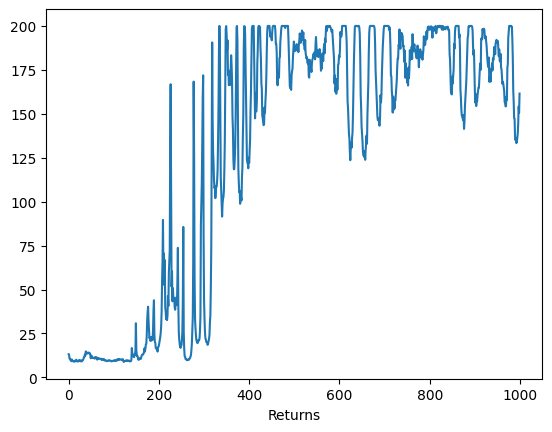

In [19]:
# Model
net = ts.utils.net.common.Net(
    env.observation_space.shape,
    env.action_space.n,
    hidden_sizes=[128, 128],
    device=device,
).to(device)

optim = torch.optim.Adam(net.parameters(), lr=0.001)

# Policy
policy = ts.policy.DQNPolicy(
    model=net, # value network
    optim=optim, # optimizer
    discount_factor=0.99, # gamma
    estimation_step=3, # n-step returns
    is_double=True, # double Q-learning
    target_update_freq=120, # how often to update the target network
    action_space=env.action_space, # action space
)
policy.set_eps(0.1) # epsilon-greedy action selection

# Collector for training
collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    buffer=ts.data.VectorReplayBuffer(20000, 10),
    exploration_noise=True
)
# Collector for testing (without exploration). No need for a buffer
test_collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=False
)
# Pre-fill the training buffer with random transitions
collector.collect(n_step=1000, random=True)

# Interaction
returns = []
for iteration in range(1000):

    # Training mode
    policy.train()

    # Exploration schedule
    if iteration <= 100:
        eps = 0.5
    elif iteration <= 900:
        eps = 0.5 - (iteration - 100) / (900 - 100) * (0.5 - 0.05)
    else:
        eps = 0.05
    policy.set_eps(eps)
    
    # Collect transitions
    result = collector.collect(n_step=1000)

    # Train DQN network on minibatch
    policy.update(
        buffer=collector.buffer,
        sample_size=0, # use the whole buffer
        batch_size=64,
        repeat=10,
    )

    # Test 10 episodes
    policy.eval()
    result = test_collector.collect(n_episode=10)
    mean_reward = result['rew']
    #print(iteration, ":", mean_reward, eps)
    returns.append(mean_reward)

plt.figure()
plt.plot(np.array(returns))
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.show()

## PPO

Now that DQN works on Cartpole, let's use PPO and compare its performance to DQN.

You will need to use the PPO policy, obviously:

```python
policy = ts.policy.PPOPolicy(
    actor=actor, 
    critic=critic, 
    optim=optim,
    dist_fn=torch.distributions.Categorical, 
    action_space=env.action_space,
    discount_factor=0.99,
    max_grad_norm=0.5,
    eps_clip=0.2,
    gae_lambda=0.95,
    deterministic_eval=True,
    action_scaling=False,
)
```

It has many more hyperparameters, which can be let at their default value (or not, depending on the time you have). Check the doc for their meaning. The important thing is that you now need an actor and a critic, not a single network.

One way to do it is to use the actor/critic specifications provided by tianshou:

```python
features = ts.utils.net.common.Net(
    state_shape=env.observation_space.shape, 
    hidden_sizes=[64, 64], 
    device=device)

actor = ts.utils.net.discrete.Actor(
    preprocess_net=features, 
    action_shape=env.action_space.n, 
    device=device).to(device)

critic = ts.utils.net.discrete.Critic(
    preprocess_net=features, 
    device=device).to(device)

actor_critic = ts.utils.net.common.ActorCritic(actor=actor, critic=critic)

optim = torch.optim.Adam(actor_critic.parameters(), lr=0.001)
```

``features`` is the shared feature extractor between the actor and the critic. ``actor`` is the policy head (one neuron per discrete action), ``critic`` is a single output neuron for the value V(s). ``actor_critic`` is the combined two-headed network. 

When defining the PPO policy, `dist_fn=torch.distributions.Categorical` specifies how exploration is performed, here a softmax over the two actions left and right. 

**Q:** Implement PPO on Cartpole. You will need to find the right hyperparameters for the task. 

Remember that learning is **on-policy**, so the transition buffer must be emptied after training the network. Your interaction loop must therefore look like this:

```python
for iteration in range(N):

    # Collect enough on-policy steps
    result = collector.collect(...)

    # Update the PP0 network by learning the on-policy buffer
    policy.update(...)

    # Empty the buffer as we are on-policy
    collector.reset_buffer(keep_statistics=False)
```

Do not hesitate to collect many on-policy steps before training the network.

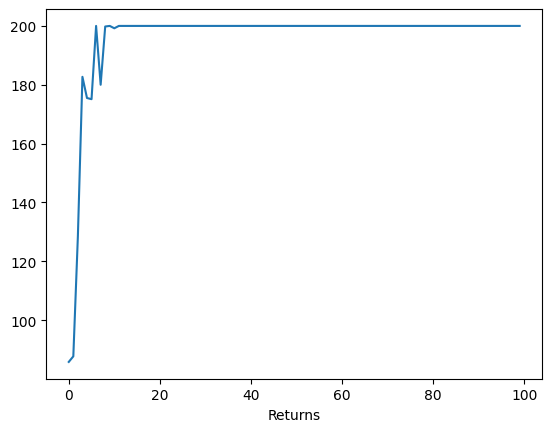

In [20]:
# Model
features = ts.utils.net.common.Net(
    state_shape=env.observation_space.shape, 
    hidden_sizes=[64, 64], 
    device=device)

actor = ts.utils.net.discrete.Actor(
    preprocess_net=features, 
    action_shape=env.action_space.n, 
    device=device).to(device)

critic = ts.utils.net.discrete.Critic(
    preprocess_net=features, 
    device=device).to(device)

actor_critic = ts.utils.net.common.ActorCritic(actor=actor, critic=critic)

optim = torch.optim.Adam(actor_critic.parameters(), lr=0.003)

# Policy
policy = ts.policy.PPOPolicy(
    actor=actor, 
    critic=critic, 
    optim=optim,
    dist_fn=torch.distributions.Categorical, 
    action_space=env.action_space,
    deterministic_eval=True,
    action_scaling=False,
    discount_factor=0.99,
    max_grad_norm=0.5,
    eps_clip=0.2,
    gae_lambda=0.95,
)

# Collector
collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]), 
    buffer=ts.data.VectorReplayBuffer(20000, 10),
    exploration_noise=True
)
test_collector = ts.data.Collector(
    policy=policy, 
    env=ts.env.DummyVectorEnv([lambda: gym.make('CartPole-v0') for _ in range(10)]),
    exploration_noise=False
)

# On-policy trainer
returns = []
for iteration in range(100):

    policy.train() 

    # Collect enough on-policy steps
    result = collector.collect(n_step=3000)

    # Update the PP0 network by learning the on-policy buffer 10 times
    policy.update(
        buffer=collector.buffer,
        sample_size=0, # use the whole buffer
        batch_size=256,
        repeat=10,
    )

    # Empty the buffer as we are on-policy
    collector.reset_buffer(keep_statistics=False)

    # Test 10 episodes
    policy.eval()
    result = test_collector.collect(n_episode=10)
    mean_reward = result['rew']
    #print(iteration, ":", mean_reward)
    returns.append(mean_reward)

plt.figure()
plt.plot(np.array(returns))
plt.xlabel("Epochs")
plt.ylabel("Returns")
plt.show()

Return: 200.0
MoviePy - Building file videos/cartpole-ppo.gif with imageio.



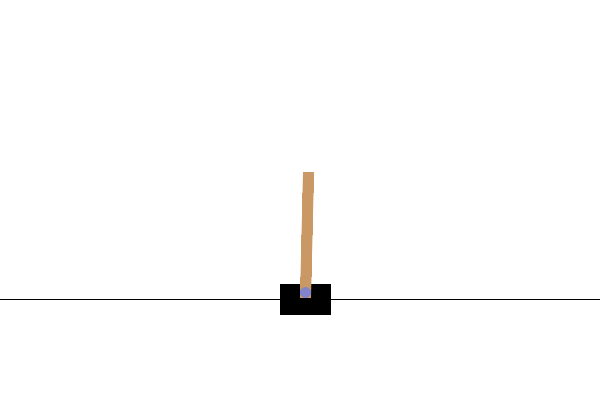

: 

In [21]:
# Evaluation mode
policy.eval() 

# Create a recordable environment
env = gym.make('CartPole-v0', render_mode="rgb_array_list")
recorder = GymRecorder(env)

# Sample the initial state
state, info = env.reset()

# One episode:
done = False
return_episode = 0
while not done:
    # Select an action from the learned policy
    action = policy.forward(ts.data.Batch(obs=[state], info=None)).act[0].numpy()
    # Sample a single transition
    next_state, reward, terminal, truncated, info = env.step(action)
    # End of the episode
    done = terminal or truncated
    # Update undiscounted return
    return_episode += reward
    # Go in the next state
    state = next_state

print("Return:", return_episode)

recorder.record(env.render())
video = "videos/cartpole-ppo.gif"
recorder.make_video(video)
ipython_display(video)

**Q:** How does it compare to DQN once the right hyperparameters are found? What is their influence? Play especially with `eps_clip`, the $\epsilon$ threshold used to clip the IS weight in the PPO loss.

**Q:** Apply PPO to more complex environments available in gymnasium. Beware that for continuous action spaces, you will need to use continuous actor/critic networks, i.e.:

```python
actor = ts.utils.net.continuous.Actor(...)
critic = ts.utils.net.continuous.Critic(...)
```

instead of:

```python
actor = ts.utils.net.discrete.Actor(...)
critic = ts.utils.net.discrete.Critic(...)
```

The `dist_fn` argument of `PPOPolicy` must also be set accordingly. Check the doc!